# Cars Brand Image Classification using CNN

Classifying car brands using convolutional neural networks (CNN) is a machine learning task that involves assigning car images to their respective brand categories. This is an example of a multi-class classification problem where our CNN is expected to predict the brand of a car based on its image. There are several challenges associated with this task:

1. Data Collection: Creating or obtaining a suitable dataset that includes images of cars from various brands is crucial. The dataset should be representative and diverse in terms of brands, models, colors, and other factors that influence brand recognition.

2. Image Preprocessing: Images need to be adequately preprocessed before feeding them into the CNN model. This may involve resizing images, normalization, noise removal, and other preprocessing operations to enhance the data quality.

3. CNN Architecture: Choosing the right CNN architecture to solve the problem of classifying car brands is essential. You can use existing architectures such as VGG, ResNet, or Inception, or customize your own architecture to suit your needs.

4. Model Training: The CNN model needs to be trained on the dataset, which involves multiple epochs of learning to adjust the model's weights for recognizing different car brands.

5. Model Evaluation: After training the model, you need to assess its performance on a test dataset. You can use various metrics such as accuracy or a confusion matrix to evaluate how well the model classifies car brands.

6. Model Optimization: If the model does not achieve satisfactory results, you may need to fine-tune its parameters, change the architecture, or increase the training dataset size to improve its performance.

7. Deployment: After creating and training the CNN model, you can deploy it in an application or service that aims to recognize car brands based on images.

Classifying car brands using convolutional neural networks is an interesting task that can be applied in various domains, such as the automotive industry, traffic monitoring, or road safety. However, its effectiveness depends on data quality and model architecture, requiring careful preparation and experimentation.

## Import libraries

In [2]:
import os
import gdown
import zipfile
import tarfile
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import glob
import fnmatch
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.legacy import RMSprop

## Datasets

Car brands immages use 100 images of top 50 car brands (US ranking) https://www.kaggle.com/datasets/yamaerenay/100-images-of-top-50-car-brands/data. 
The Most Popular Car Brands in America
According to recent studies, the most popular car brands in America are Ford, Toyota, Chevrolet, Honda, and Nissan. These five brands dominate the American auto market and have consistently been among the top-selling car brands in the country.

Ford has been a leading car brand in America for over a century and is known for its high-quality vehicles, including the most popular Ford F-series pickup. Toyota is another popular car brand in America, known for its reliable and efficient cars, such as the RAV4 and Camry. Chevrolet, a division of General Motors, is also a popular choice for American car buyers, such as the Silverado and Equinox.

Of course, there are many other car brands available in America, including luxury brands like BMW, Mercedes-Benz, and Lexus, as well as relatively small Japanese manufacturers like Subaru and Mazda.

Let's take a look, Which car brands are on the list.

The ranking is based on 2021 sales in the US, but some brands do not have data available.

Here is the Full Ranking List (Top 50)
Toyota, Ford, Chevrolet, Honda, Nissan, Jeep, Hyundai, Kia, Ram Trucks, Subaru, GMC, Volkswagen, BMW, Mazda, Mercedes-Benz, Lexus, Tesla, Dodge, Audi, Buick, Acura, Volvo, Cadillac, Chrysler, Mitsubishi, Land Rover, Lincoln, Porsche, Infiniti, Genesis, Mini, Maserati, Alfa Romeo, Jaguar, Bentley, Ferrari, Lamborghini, Aston Martin, Polestar, Fiat, Rolls-Royce, McLaren, Lucid, Bugatti, Lotus, Rivian, Canoo, Pontiac, Oldsmobile, Rimac,

Even though some car brands have closed down or reduced their operations in the United States market, they are still very popular among American consumers. For example, Pontiac, Saturn and Oldsmobile were all General Motors (GM) brands that were discontinued in the 2000s, but many of their models still have a loyal following in the used car market.

Similarly, other brands like Plymouth and Mercury have also been discontinued, but their cars remain popular among collectors and enthusiasts. Moreover, some foreign brands like Saab and Suzuki have also left the US market, but they still have a dedicated fan base that appreciates their unique features and designs.

Overall, the popularity of a car brand is not only determined by its availability in the market, but also by its reputation, quality, and performance. Even though some car brands have closed down, they have left a lasting impact on the American car industry and continue to be remembered and appreciated by their fans.

## Loading data

Creating the data directory and unpacking the contents into it using archive.zip. Then, in the data directory, create a structure of images/train and images/test directories for 10 classes - car brands. Then copying the contents of the dataset to the train and test directories in an 80/20 ratio.

In [2]:
# Delete the data and models folder if it exists
!rm -Rf data
!rm -Rf models

In [3]:
# Unpacking files from the zip archive

with zipfile.ZipFile("archive.zip","r") as zip_ref:
    zip_ref.extractall("data")

In [4]:
# Creating directories for training and test files

location = 'data'
directories = ['images', 'images/train', 'images/test']
for directory in directories:
    os.mkdir(os.path.join(location, directory))

In [5]:
# Creating classes of car brands and dividing the files into 80% training and 20% testing

path = 'data/imgs_zip/imgs/'

# Select 10 first car brand classes

for class_ in os.listdir(path)[:10]:
    #print(str(class_))
    os.mkdir('data/images/train/'+class_)
    os.mkdir('data/images/test/'+class_)
    
    data = os.listdir(path+class_)
    for img in itertools.islice(glob.iglob(os.path.join(path+class_, '*jpg')), 
                                 len(data[:round(len(data)*0.8)])):
        shutil.copy(img, 'data/images/train/'+class_)
        
    for img in itertools.islice(glob.iglob(os.path.join(path+class_, '*jpg')), 
                                 len(data[:round(len(data)*0.8)]), len(data)):
        shutil.copy(img, 'data/images/test/'+class_)

## Data mining

W tej części pokazuje ile zdjęć jest w zbiorze treningowym i testowym dla danej klasy. Pokazuje też przykładowe zdjęcia dla grupy treningowej i testowej.

In [225]:
# Listing the names of car brand folders from the train folder

data_train = []
path = 'data/images/train/'
for class_ in os.listdir('data/images/train'):
    count = len(fnmatch.filter(os.listdir(path+class_), '*.jpg'))
    data_train.append([class_, count])

In [226]:
data_train

[['Volkswagen', 75],
 ['Porsche', 71],
 ['Studebaker', 82],
 ['Bugatti', 74],
 ['Mitsubishi', 70],
 ['Renault', 70],
 ['GMC', 75],
 ['Hudson', 82],
 ['Ferrari', 78],
 ['Ford', 71]]

In [227]:
# Listing the names of car brand folders from the train folder

data_test = []
path = 'data/images/test/'
for class_ in os.listdir('data/images/test'):
    count = len(fnmatch.filter(os.listdir(path+class_), '*.jpg'))
    data_test.append([class_, count])

In [228]:
data_test

[['Volkswagen', 19],
 ['Porsche', 18],
 ['Studebaker', 20],
 ['Bugatti', 18],
 ['Mitsubishi', 18],
 ['Renault', 17],
 ['GMC', 19],
 ['Hudson', 20],
 ['Ferrari', 20],
 ['Ford', 18]]

In [229]:
# Listing of file names from the sample training folder

os.listdir('data/images/train/'+class_)[:10]

['Ford_017.jpg',
 'Ford_003.jpg',
 'Ford_002.jpg',
 'Ford_016.jpg',
 'Ford_028.jpg',
 'Ford_000.jpg',
 'Ford_014.jpg',
 'Ford_015.jpg',
 'Ford_001.jpg',
 'Ford_029.jpg']

(-0.5, 258.5, 193.5, -0.5)

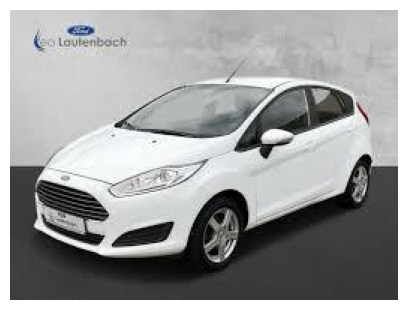

In [235]:
# Listing a sample car image from train images
data = os.listdir('data/images/train/'+class_)
img = image.load_img('data/images/train/'+class_+'/'+data[0])

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 371.5, 134.5, -0.5)

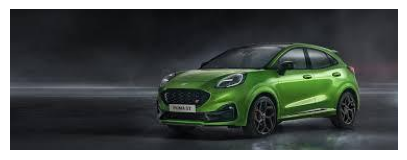

In [236]:
# Listing a sample car image from train images
data = os.listdir('data/images/test/'+class_)
img = image.load_img('data/images/test/'+class_+'/'+data[0])

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

## Data augmentation

Data augmentation is a technique applied in machine learning, especially for models processing images like Convolutional Neural Networks (CNNs). Its purpose is to increase the amount of available training data by introducing various transformations to existing images. 

Data augmentation is used in this case:

- Increase Data Diversity: Images of car brands can vary in terms of viewing angles, lighting, perspective, or car positions. Data augmentation allows the model to learn to recognize objects in different contexts, which can improve its overall classification ability.
- Reduce Overfitting: Data augmentation helps reduce the problem of model overfitting. By introducing random transformations, the model will not memorize specific training images, which can improve its ability to generalize to new images.
- Boost Training Examples: By generating different variants of images, data augmentation effectively increases the number of available training examples, which can help in training the model, especially for small datasets.
- Enhance Model Stability: The model becomes more stable and flexible, making it less susceptible to variations in the training data.

Ultimately, data augmentation helps improve the quality and performance of the CNN model for classifying car brands by involving it in the learning process with more diverse and transformed data.

In [10]:
# Generate batches of tensor image data with real-time data augmentation

train_datagen = ImageDataGenerator(
     rotation_range=30, # angle range by which the images will randomly rotate
     rescale=1./255.,
     width_shift_range=0.1, # vertical image transformations
     height_shift_range=0.1, # horizontal image transformations
     shear_range=0.1, # random image cropping range
     zoom_range=0.2, # random image zoom range
     horizontal_flip=True, # random flip of half the image in the horizontal plane
     fill_mode='nearest' # strategy for filling newly created pixels that may result from transformations
)

train_gen = train_datagen.flow_from_directory('data/images/train',
                                              target_size=(128, 128),
                                              batch_size=32,
                                              class_mode='categorical')
test_gen = ImageDataGenerator().flow_from_directory('data/images/test',
                                                    target_size=(128, 128),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 748 images belonging to 10 classes.
Found 187 images belonging to 10 classes.


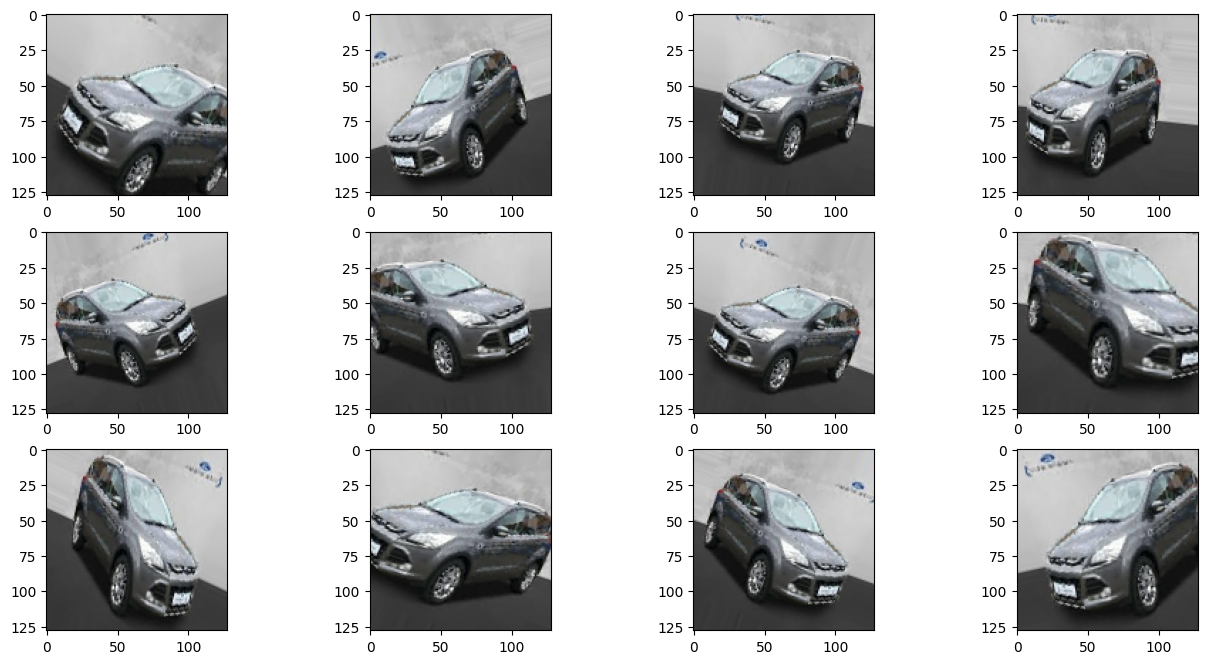

In [11]:
# Sample images obtained using the technique data augmentation

img = image.load_img('data/images/train/'+class_+'/'+data[10],target_size=(128, 128))# plt.imshow(img)
#img = image.load_img(img_path, target_size=(128, 128))

x = image.img_to_array(img)
x = x.reshape((1, ) + x.shape)

i = 1
plt.figure(figsize=(16, 8))
for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(3, 4, i)
    plt.grid(False)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 13 == 0:
        break

##  Model construction

The provided Python function, plot_hist(history), is designed to visualize and plot the training history of a machine learning model, particularly for deep learning models such as neural networks. It takes the model's training history as input and generates two subplots to show changes in training loss and accuracy over epochs.

The purpose of this function is to provide a quick and convenient way to visualize how a machine learning model is performing during training by showing the changes in loss and accuracy metrics over training epochs. This can be helpful for understanding the model's convergence, overfitting, and overall performance.

In [12]:
# Create function to plot model history information

def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    fig,axes = plt.subplots(2,1, figsize=(8,6))
    fig.suptitle("The model 's evaluation ",fontsize=20)
    axes[0].plot(hist['loss'])
    axes[0].plot(hist['val_loss'])
    #axes[0].set_title('Model Loss')
    axes[0].set_ylabel('Loss')
    axes[0].set_yscale('log')
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(hist['accuracy'])
    axes[1].plot(hist['val_accuracy'])
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['accuracy','val_accuracy'])
    plt.show()

### CNN

The provided code defines a Convolutional Neural Network (CNN) model using Keras with the following architecture:

- Input Layer: The model starts with an input layer that takes images of size 128x128 pixels with three channels (RGB).
- Convolutional Layers: Two convolutional layers (Conv2D) with 32 filters of size 5x5 each are added. These layers use the ReLU activation function, which deactivates non-responsive neurons. Both layers use 'Same' padding, meaning input images are padded to the same size.
- Max-Pooling Layer: Following each pair of convolutional layers, there is a Max-Pooling layer (MaxPool2D) with a 2x2 pool size, which helps reduce the dimensionality of processed data and extract significant features.
- Dropout Layer: After each Max-Pooling layer, a Dropout layer is included to assist in model regularization by randomly deactivating some neurons, reducing the risk of overfitting.
- The above steps are repeated in two subsequent blocks: two convolutional layers, a Max-Pooling layer, and a Dropout layer.
- Flatten Layer: After processing through convolutional and Max-Pooling layers, the data is flattened into a single vector using a Flatten layer to be passed to fully connected layers.
- Fully Connected Layers: The model includes two fully connected layers (Dense). The first has 256 neurons with the ReLU activation function, and the second has 10 neurons with the softmax activation function. The final layer serves as the output layer for classifying into 10 classes. The softmax function generates probabilities for each class.
- Model Compilation: The model is compiled using the 'categorical_crossentropy' loss function, 'rmsprop' optimizer, and accuracy metric.
- Model Summary: Finally, the model.summary() function is called to generate a summary of the model's architecture, displaying the number of parameters and dimensions for each layer.

This model is a typical example of a CNN for image classification. It is designed for recognizing objects in 128x128-pixel images and is structured to leverage convolutions, max-pooling, and regularization to effectively learn and classify images.

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                  activation ='relu', input_shape = (128, 128,3)))
model.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))


model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(layers.Dropout(0.25))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation = "relu"))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation = "softmax"))
model.compile(loss=categorical_crossentropy, optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

In [14]:
history = model.fit(train_gen, validation_data=test_gen, batch_size=128, epochs=20)

Epoch 1/20
24/24 [==============================] - 19s 774ms/step - loss: 2.8219 - accuracy: 0.0896 - val_loss: 20.6620 - val_accuracy: 0.1016
Epoch 2/20
24/24 [==============================] - 18s 758ms/step - loss: 2.3676 - accuracy: 0.1310 - val_loss: 6.0435 - val_accuracy: 0.1658
Epoch 3/20
24/24 [==============================] - 18s 766ms/step - loss: 2.2697 - accuracy: 0.1591 - val_loss: 51.6569 - val_accuracy: 0.1979
Epoch 4/20
24/24 [==============================] - 18s 766ms/step - loss: 2.2081 - accuracy: 0.1845 - val_loss: 128.9113 - val_accuracy: 0.2086
Epoch 5/20
24/24 [==============================] - 19s 778ms/step - loss: 2.2177 - accuracy: 0.1765 - val_loss: 111.8923 - val_accuracy: 0.1765
Epoch 6/20
24/24 [==============================] - 19s 791ms/step - loss: 2.1842 - accuracy: 0.2072 - val_loss: 123.9307 - val_accuracy: 0.2086
Epoch 7/20
24/24 [==============================] - 19s 791ms/step - loss: 2.1519 - accuracy: 0.2233 - val_loss: 165.4186 - val_accura

In [15]:
hist_df_cnn = pd.DataFrame(history.history)

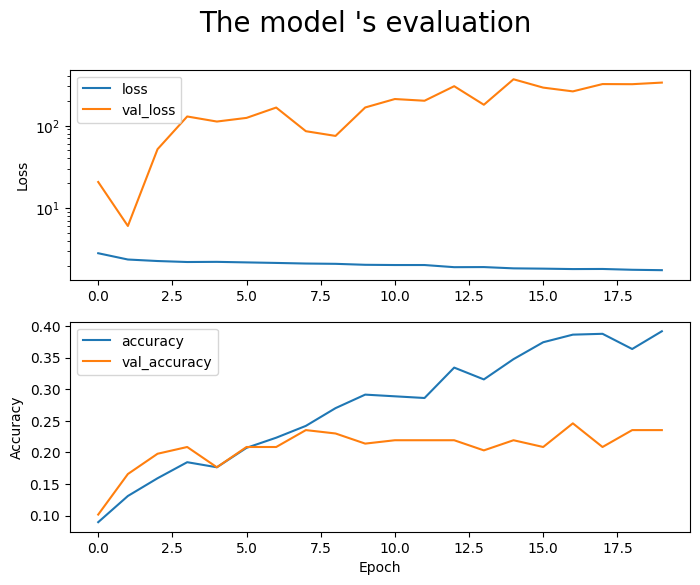

In [16]:
plot_hist(history)

In [17]:
os.mkdir('models')

In [18]:
model.save('models/cnn_model_10.h5')

/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Vgg16

In [19]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
conv_base.trainable = False

In [20]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 16814666 (64.14 MB)
Trainable params: 2099978 (8.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [21]:
history = model.fit(train_gen, validation_data=test_gen, batch_size=128, epochs=20)

Epoch 1/20
24/24 [==============================] - 29s 1s/step - loss: 2.7251 - accuracy: 0.1912 - val_loss: 17.1764 - val_accuracy: 0.3209
Epoch 2/20
24/24 [==============================] - 32s 1s/step - loss: 1.8456 - accuracy: 0.3663 - val_loss: 22.4004 - val_accuracy: 0.3797
Epoch 3/20
24/24 [==============================] - 33s 1s/step - loss: 1.6187 - accuracy: 0.4505 - val_loss: 24.2965 - val_accuracy: 0.4225
Epoch 4/20
24/24 [==============================] - 34s 1s/step - loss: 1.4729 - accuracy: 0.5214 - val_loss: 31.3421 - val_accuracy: 0.4171
Epoch 5/20
24/24 [==============================] - 33s 1s/step - loss: 1.3045 - accuracy: 0.5615 - val_loss: 30.3741 - val_accuracy: 0.4706
Epoch 6/20
24/24 [==============================] - 34s 1s/step - loss: 1.2900 - accuracy: 0.5602 - val_loss: 35.3662 - val_accuracy: 0.4492
Epoch 7/20
24/24 [==============================] - 34s 1s/step - loss: 1.1488 - accuracy: 0.6136 - val_loss: 36.6638 - val_accuracy: 0.4599
Epoch 8/20
24

In [22]:
hist_df_vgg = pd.DataFrame(history.history)

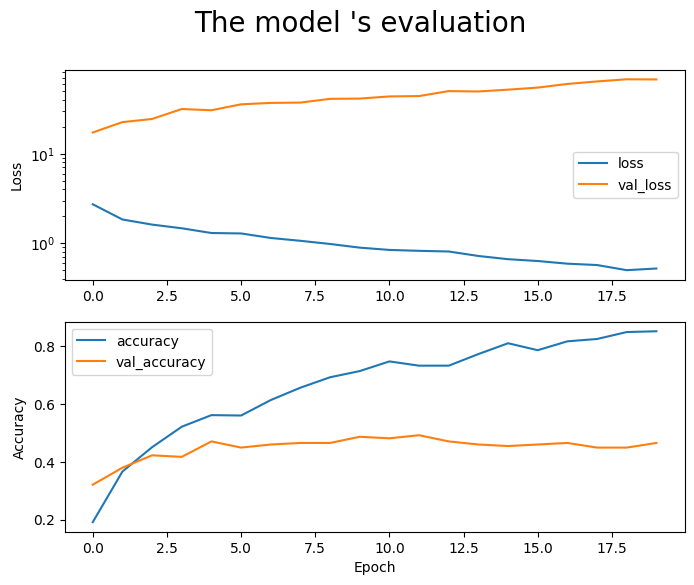

In [23]:
plot_hist(history)

In [24]:
model.save('models/vgg16_model_10.h5')

/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### ResNet50

In [25]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
conv_base.trainable = False

In [26]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               8388864   
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 31979146 (121.99 MB)
Trainable params: 8391434 (32.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [27]:
history = model.fit(train_gen, validation_data=test_gen, batch_size=128, epochs=20)

Epoch 1/20
24/24 [==============================] - 12s 458ms/step - loss: 2.7815 - accuracy: 0.1190 - val_loss: 6.0913 - val_accuracy: 0.1016
Epoch 2/20
24/24 [==============================] - 11s 452ms/step - loss: 2.3060 - accuracy: 0.1430 - val_loss: 7.5623 - val_accuracy: 0.0909
Epoch 3/20
24/24 [==============================] - 11s 448ms/step - loss: 2.2639 - accuracy: 0.1858 - val_loss: 9.0977 - val_accuracy: 0.1016
Epoch 4/20
24/24 [==============================] - 11s 454ms/step - loss: 2.2519 - accuracy: 0.1979 - val_loss: 12.1373 - val_accuracy: 0.1016
Epoch 5/20
24/24 [==============================] - 11s 452ms/step - loss: 2.2520 - accuracy: 0.1791 - val_loss: 12.8259 - val_accuracy: 0.1016
Epoch 6/20
24/24 [==============================] - 11s 465ms/step - loss: 2.2263 - accuracy: 0.2099 - val_loss: 15.0283 - val_accuracy: 0.1016
Epoch 7/20
24/24 [==============================] - 11s 464ms/step - loss: 2.1961 - accuracy: 0.2032 - val_loss: 16.6347 - val_accuracy: 0.

In [28]:
hist_df_resnet = pd.DataFrame(history.history)

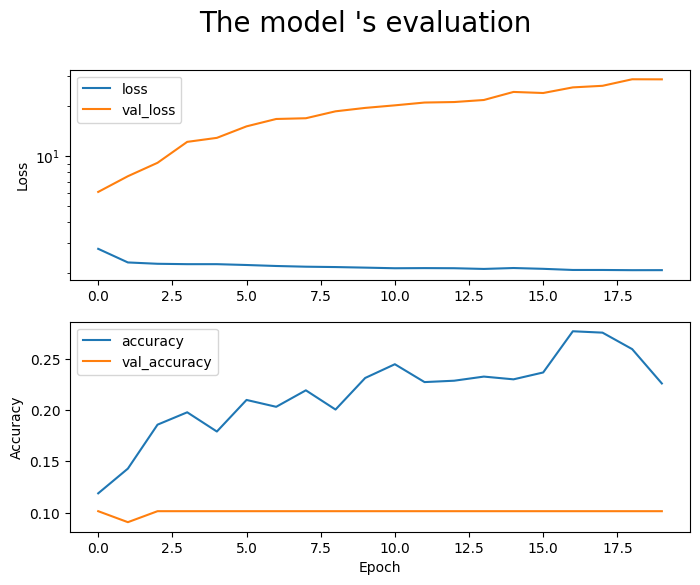

In [29]:
plot_hist(history)

In [30]:
model.save('models/resnet50_model_10.h5')

/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### InceptionV3

In [31]:
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
conv_base.trainable = False

In [32]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dense_7 (Dense)             (None, 10)                2570      
                                                                 
Total params: 23902762 (91.18 MB)
Trainable params: 2099978 (8.01 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [33]:
history = model.fit(train_gen, validation_data=test_gen, batch_size=128, epochs=20)

Epoch 1/20
24/24 [==============================] - 7s 225ms/step - loss: 6.8824 - accuracy: 0.1725 - val_loss: 39.4465 - val_accuracy: 0.0802
Epoch 2/20
24/24 [==============================] - 5s 212ms/step - loss: 1.9761 - accuracy: 0.3302 - val_loss: 40.9057 - val_accuracy: 0.0963
Epoch 3/20
24/24 [==============================] - 5s 221ms/step - loss: 1.7772 - accuracy: 0.3917 - val_loss: 49.7040 - val_accuracy: 0.1283
Epoch 4/20
24/24 [==============================] - 5s 218ms/step - loss: 1.6607 - accuracy: 0.4225 - val_loss: 47.7734 - val_accuracy: 0.1176
Epoch 5/20
24/24 [==============================] - 5s 223ms/step - loss: 1.5189 - accuracy: 0.4906 - val_loss: 68.6664 - val_accuracy: 0.1176
Epoch 6/20
24/24 [==============================] - 6s 233ms/step - loss: 1.5617 - accuracy: 0.4652 - val_loss: 61.8807 - val_accuracy: 0.1070
Epoch 7/20
24/24 [==============================] - 6s 235ms/step - loss: 1.6037 - accuracy: 0.4679 - val_loss: 75.7784 - val_accuracy: 0.1070

In [34]:
hist_df_inception = pd.DataFrame(history.history)

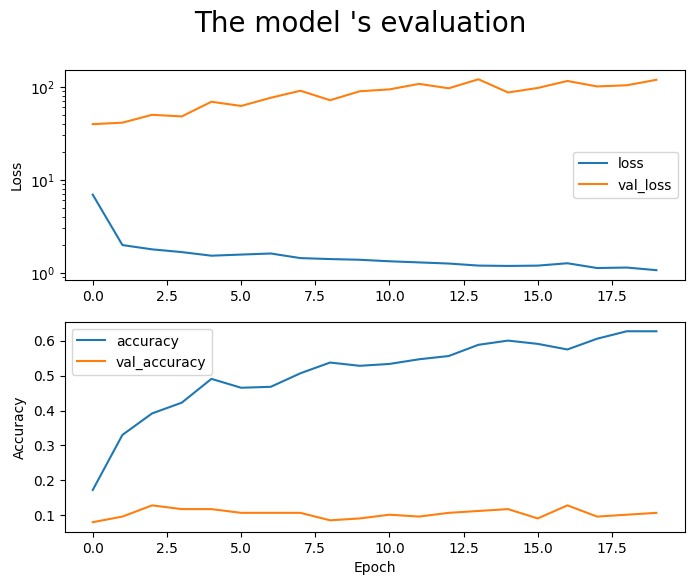

In [35]:
plot_hist(history)

In [36]:
model.save('models/inceptionv3_model_10.h5')

/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluation of models on the test set

In [37]:
# Preparation of test data

test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    'data/images/test',
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 187 images belonging to 10 classes.


In [38]:
# Raad class indices

test_generator.class_indices

{'Bugatti': 0,
 'Ferrari': 1,
 'Ford': 2,
 'GMC': 3,
 'Hudson': 4,
 'Mitsubishi': 5,
 'Porsche': 6,
 'Renault': 7,
 'Studebaker': 8,
 'Volkswagen': 9}

In [39]:
classes = list(test_generator.class_indices.keys())

In [40]:
# Show input test data class matrix
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], dtype=int32)

In [43]:
# Load models
cnn_model = load_model('models/cnn_model_10.h5')
vgg_model = load_model('models/vgg16_model_50.h5')
resnet_model = load_model('models/resnet50_model_10.h5')
inc_model = load_model('models/inceptionv3_model_10.h5')

### CNN

In [44]:
# Predict cnn model

y_prob = cnn_model.predict(test_generator, test_generator.samples)

187/187 [==============================] - 2s 10ms/step


In [45]:
y_pred_cnn = np.argmax(y_prob, axis=1)

In [46]:
# Show confusion matrix

cm = confusion_matrix(y_true, y_pred_cnn)
cm

array([[ 4,  0,  4,  1,  0,  3,  0,  1,  3,  2],
       [ 2,  9,  3,  0,  0,  3,  0,  3,  0,  0],
       [ 1,  2,  6,  0,  0,  2,  2,  1,  4,  0],
       [ 2,  0,  2,  1,  3,  3,  0,  4,  4,  0],
       [ 1,  0,  3,  0, 12,  1,  0,  1,  2,  0],
       [ 2,  0,  3,  0,  0,  6,  0,  2,  5,  0],
       [ 3,  1,  3,  0,  0,  7,  1,  1,  1,  1],
       [ 5,  0,  2,  1,  2,  3,  0,  3,  1,  0],
       [ 0,  2,  5,  1,  2,  3,  0,  2,  4,  1],
       [ 2,  0,  5,  3,  2,  1,  0,  2,  3,  1]])

In [16]:
def plot_confusion_matrix(cm):
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = classes)
    fig, ax = plt.subplots(figsize=(10,10))
    display.plot(ax=ax, xticks_rotation='vertical')
    plt.show()

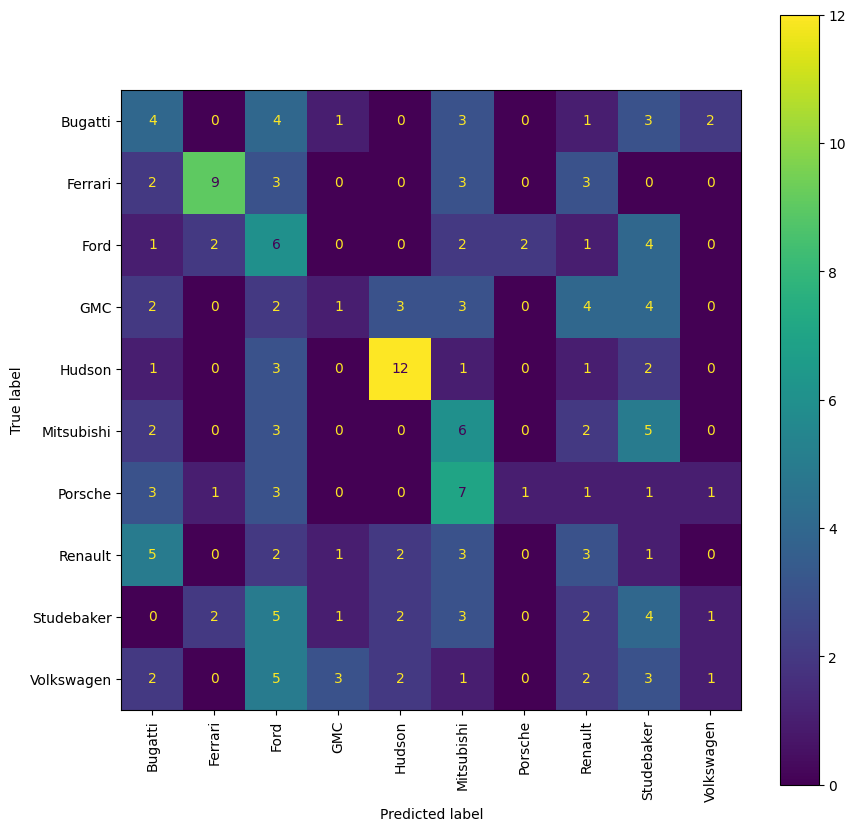

In [50]:
plot_confusion_matrix(cm)

In [51]:
print(classification_report(y_true, y_pred_cnn, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

     Bugatti       0.18      0.22      0.20        18
     Ferrari       0.64      0.45      0.53        20
        Ford       0.17      0.33      0.22        18
         GMC       0.14      0.05      0.08        19
      Hudson       0.57      0.60      0.59        20
  Mitsubishi       0.19      0.33      0.24        18
     Porsche       0.33      0.06      0.10        18
     Renault       0.15      0.18      0.16        17
  Studebaker       0.15      0.20      0.17        20
  Volkswagen       0.20      0.05      0.08        19

    accuracy                           0.25       187
   macro avg       0.27      0.25      0.24       187
weighted avg       0.28      0.25      0.24       187



### VGG16

In [52]:
# Predict model

y_prob = vgg_model.predict(test_generator, test_generator.samples)

187/187 [==============================] - 8s 40ms/step


In [53]:
y_pred_vgg = np.argmax(y_prob, axis=1)

In [54]:
# Show confusion matrix

cm = confusion_matrix(y_true, y_pred_vgg)
cm

array([[ 9,  3,  1,  0,  0,  0,  4,  1,  0,  0],
       [ 3, 12,  0,  0,  0,  1,  1,  3,  0,  0],
       [ 4,  1,  4,  0,  0,  4,  0,  3,  1,  1],
       [ 0,  1,  0, 11,  1,  1,  1,  2,  2,  0],
       [ 0,  1,  0,  0, 13,  0,  1,  0,  5,  0],
       [ 1,  0,  0,  1,  0, 11,  1,  0,  2,  2],
       [ 1,  3,  3,  0,  0,  3,  2,  3,  1,  2],
       [ 0,  0,  0,  0,  0,  0,  1, 14,  1,  1],
       [ 0,  0,  1,  1,  0,  0,  0,  0, 18,  0],
       [ 3,  1,  0,  0,  0,  2,  2,  2,  2,  7]])

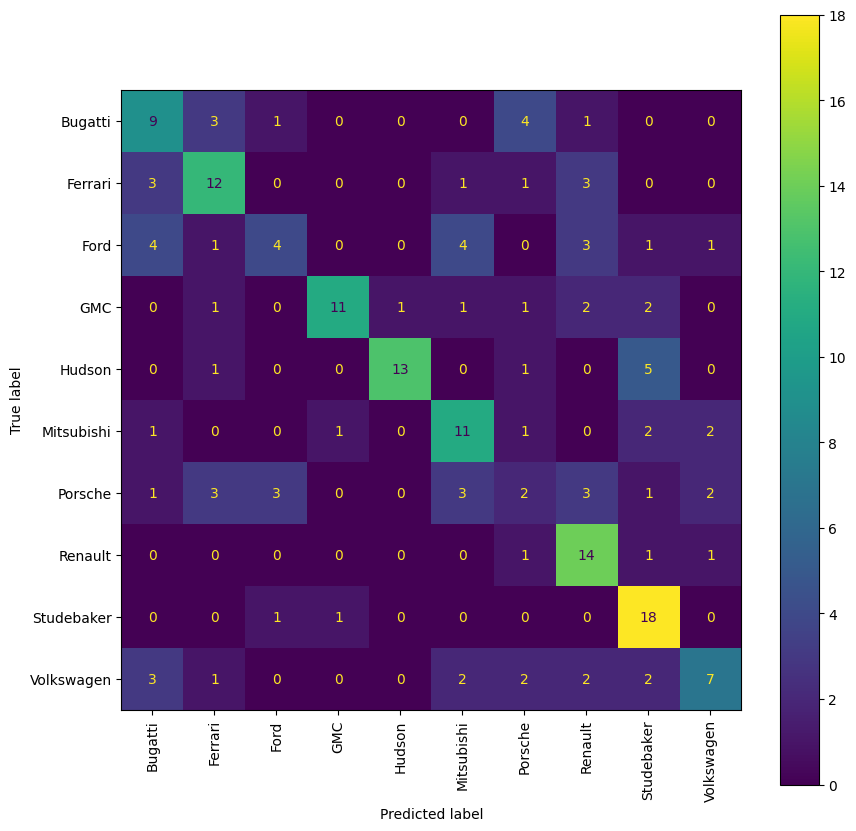

In [55]:
plot_confusion_matrix(cm)

In [56]:
print(classification_report(y_true, y_pred_vgg, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

     Bugatti       0.43      0.50      0.46        18
     Ferrari       0.55      0.60      0.57        20
        Ford       0.44      0.22      0.30        18
         GMC       0.85      0.58      0.69        19
      Hudson       0.93      0.65      0.76        20
  Mitsubishi       0.50      0.61      0.55        18
     Porsche       0.15      0.11      0.13        18
     Renault       0.50      0.82      0.62        17
  Studebaker       0.56      0.90      0.69        20
  Volkswagen       0.54      0.37      0.44        19

    accuracy                           0.54       187
   macro avg       0.54      0.54      0.52       187
weighted avg       0.55      0.54      0.53       187



### ResNet50

In [57]:
# Predict model

y_prob = resnet_model.predict(test_generator, test_generator.samples)

187/187 [==============================] - 5s 26ms/step


In [58]:
y_pred_res = np.argmax(y_prob, axis=1)

In [59]:
# Show confusion matrix

cm = confusion_matrix(y_true, y_pred_res)
cm

array([[ 1,  0, 16,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  1, 11,  1,  0,  0,  0,  3,  4,  0],
       [ 0,  0, 10,  0,  2,  0,  0,  4,  2,  0],
       [ 0,  0, 11,  0,  3,  0,  0,  5,  0,  0],
       [ 0,  0,  7,  0, 10,  0,  0,  1,  2,  0],
       [ 0,  0, 14,  1,  0,  1,  0,  1,  1,  0],
       [ 0,  0, 11,  0,  0,  0,  0,  4,  3,  0],
       [ 0,  0,  8,  1,  1,  0,  0,  5,  2,  0],
       [ 0,  0,  7,  1,  0,  0,  0,  2, 10,  0],
       [ 1,  1,  7,  1,  1,  0,  0,  5,  2,  1]])

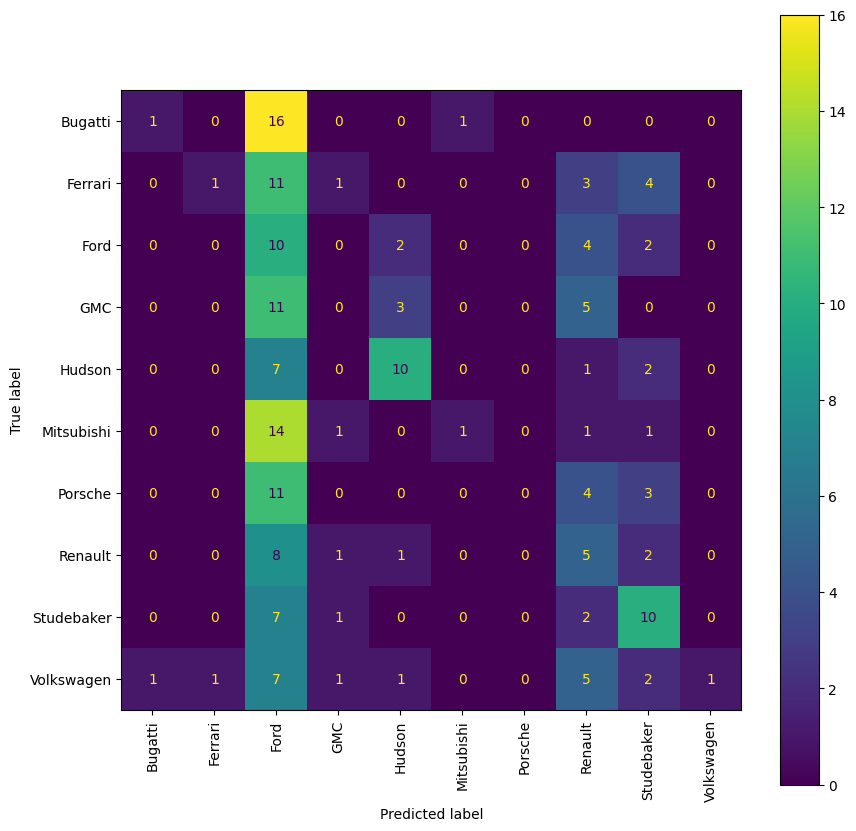

In [60]:
plot_confusion_matrix(cm)

In [61]:
print(classification_report(y_true, y_pred_res, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

     Bugatti       0.50      0.06      0.10        18
     Ferrari       0.50      0.05      0.09        20
        Ford       0.10      0.56      0.17        18
         GMC       0.00      0.00      0.00        19
      Hudson       0.59      0.50      0.54        20
  Mitsubishi       0.50      0.06      0.10        18
     Porsche       0.00      0.00      0.00        18
     Renault       0.17      0.29      0.21        17
  Studebaker       0.38      0.50      0.43        20
  Volkswagen       1.00      0.05      0.10        19

    accuracy                           0.21       187
   macro avg       0.37      0.21      0.17       187
weighted avg       0.38      0.21      0.18       187



/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### InceptionV3

In [62]:
# Predict model

y_prob = inc_model.predict(test_generator, test_generator.samples)

187/187 [==============================] - 3s 14ms/step


In [63]:
y_pred_inc = np.argmax(y_prob, axis=1)

In [64]:
# Show confusion matrix

cm = confusion_matrix(y_true, y_pred_inc)
cm

array([[10,  1,  0,  0,  0,  1,  5,  1,  0,  0],
       [ 5,  8,  0,  0,  2,  1,  3,  0,  1,  0],
       [ 1,  2,  2,  0,  1,  7,  1,  3,  0,  1],
       [ 0,  0,  0,  8,  0,  4,  0,  0,  2,  5],
       [ 1,  0,  0,  0, 16,  0,  1,  0,  2,  0],
       [ 1,  0,  0,  1,  1, 10,  0,  4,  0,  1],
       [10,  1,  0,  0,  1,  2,  2,  1,  0,  1],
       [ 6,  1,  1,  0,  1,  3,  1,  4,  0,  0],
       [ 1,  0,  0,  2,  0,  1,  1,  0, 15,  0],
       [ 3,  0,  1,  0,  4,  2,  4,  1,  1,  3]])

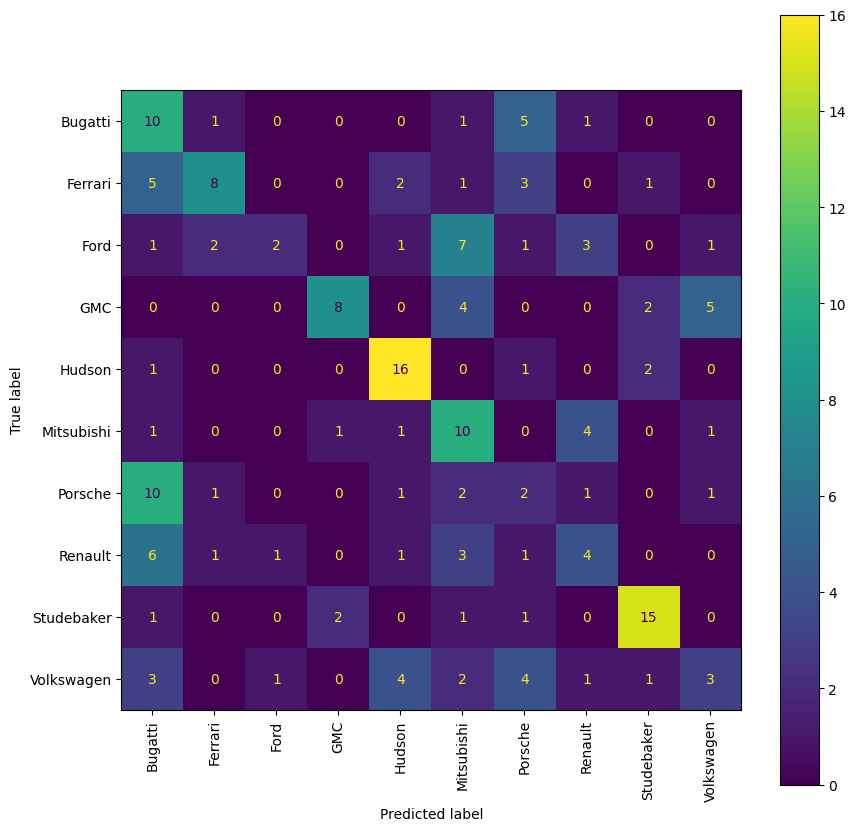

In [65]:
plot_confusion_matrix(cm)

In [66]:
print(classification_report(y_true, y_pred_inc, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

     Bugatti       0.26      0.56      0.36        18
     Ferrari       0.62      0.40      0.48        20
        Ford       0.50      0.11      0.18        18
         GMC       0.73      0.42      0.53        19
      Hudson       0.62      0.80      0.70        20
  Mitsubishi       0.32      0.56      0.41        18
     Porsche       0.11      0.11      0.11        18
     Renault       0.29      0.24      0.26        17
  Studebaker       0.71      0.75      0.73        20
  Volkswagen       0.27      0.16      0.20        19

    accuracy                           0.42       187
   macro avg       0.44      0.41      0.40       187
weighted avg       0.45      0.42      0.40       187



## Summary

Analyzing the obtained result, the best results are obtained by the VGG16 model, as evidenced by an accuracy of 0.68 and an f1-score of 0.66

In [68]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred_inc}, index=test_generator.filenames)
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred'])
print('Errors in all test files (187):')
errors['is_incorrect'].sum()

Errors in all test files (187):


109

In [69]:
errors

,y_true,y_pred,is_incorrect
Bugatti/Bugatti_000.jpg,0,1,True
Bugatti/Bugatti_001.jpg,0,7,True
Bugatti/Bugatti_002.jpg,0,6,True
Bugatti/Bugatti_003.jpg,0,6,True
Bugatti/Bugatti_004.jpg,0,0,False
...,...,...,...
Volkswagen/Volkswagen_075.jpg,9,4,True
Volkswagen/Volkswagen_076.jpg,9,7,True
Volkswagen/Volkswagen_077.jpg,9,6,True
Volkswagen/Volkswagen_088.jpg,9,5,True


1/1 [==============================] - 0s 22ms/step
{'Class': 'Bugatti', 'Probability': 0.86234593}


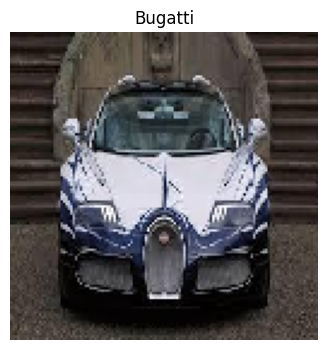

In [70]:
# Correct prediction

img_path = os.path.join('data/images/test', errors.index[4])
img = image.load_img(img_path)
new_img = image.load_img(img_path, target_size=(128, 128))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

img_class = inc_model.predict(img)
img_class_index =np.argmax(img_class)
classname = classes[img_class_index]
prediction = inc_model.predict(img).max()

pred_dict = {"Class":classname, "Probability":prediction}
print(pred_dict)

#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(classname)
plt.show()

In [71]:
errors.index[4], classes, inc_model.predict(img)

1/1 [==============================] - 0s 29ms/step


('Bugatti/Bugatti_004.jpg',
 ['Bugatti',
  'Ferrari',
  'Ford',
  'GMC',
  'Hudson',
  'Mitsubishi',
  'Porsche',
  'Renault',
  'Studebaker',
  'Volkswagen'],
 array([[8.6234593e-01, 1.6044484e-02, 2.7504167e-02, 6.6893008e-05,
         1.5919589e-02, 2.0351179e-02, 1.3414119e-02, 4.0275645e-03,
         6.0876697e-05, 4.0265113e-02]], dtype=float32))

1/1 [==============================] - 0s 22ms/step
{'Class': 'Porsche', 'Probability': 0.6308828}


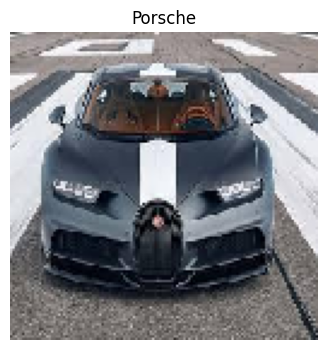

In [72]:
# Inorrect prediction

img_path = os.path.join('data/images/test', errors.index[2])
img = image.load_img(img_path)
new_img = image.load_img(img_path, target_size=(128, 128))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

img_class = inc_model.predict(img)
img_class_index =np.argmax(img_class)
classname = classes[img_class_index]
prediction = inc_model.predict(img).max()

pred_dict = {"Class":classname, "Probability":prediction}
print(pred_dict)

#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(classname)
plt.show()

In [73]:
errors.index[2], classes, inc_model.predict(img)

1/1 [==============================] - 0s 31ms/step


('Bugatti/Bugatti_002.jpg',
 ['Bugatti',
  'Ferrari',
  'Ford',
  'GMC',
  'Hudson',
  'Mitsubishi',
  'Porsche',
  'Renault',
  'Studebaker',
  'Volkswagen'],
 array([[2.0384736e-01, 7.4957296e-02, 2.7546065e-03, 1.2219634e-05,
         8.4728748e-03, 7.6749469e-03, 6.3088280e-01, 1.3255663e-02,
         5.8365589e-05, 5.8083836e-02]], dtype=float32))

# Build and test final model

## Dataset 
60,000+ Images of Cars - The Car Connection Picture Dataset
https://www.kaggle.com/datasets/prondeau/the-car-connection-picture-dataset

In [76]:
url = 'https://drive.google.com/file/d/1BgoGWzoGKhF6nxG9jqVDA0B1_P67Eq5Z/view?usp=drive_link'
output = 'carsimg.tar.gz'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1BgoGWzoGKhF6nxG9jqVDA0B1_P67Eq5Z
From (redirected): https://drive.google.com/uc?id=1BgoGWzoGKhF6nxG9jqVDA0B1_P67Eq5Z&confirm=t&uuid=9e6569cd-0f81-4bdd-9934-18fa48c0c29d
To: /Users/marcin/workspace/Car_brand_CNN/carsimg.tar.gz
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 674M/674M [02:06<00:00, 5.31MB/s]


'carsimg.tar.gz'

In [79]:
file = tarfile.open(output)
file.extractall('.')
file.close()

In [106]:
!rm -Rf data2

In [107]:
# Creating directories for training and test files
os.mkdir('data2')
location = 'data2'
directories = ['images', 'images/train', 'images/test']
for directory in directories:
    os.mkdir(os.path.join(location, directory))

In [108]:
# Creating classes of car brands and dividing the files into 80% training and 20% testing

path = 'carsimg/'

for class_ in os.listdir(path)[:10]:
    #print(str(class_))
    os.mkdir('data2/images/train/'+class_)
    os.mkdir('data2/images/test/'+class_)
    
    data = os.listdir(path+class_)
    for img in itertools.islice(glob.iglob(os.path.join(path+class_, '*jpg')), 
                                 len(data[:round(len(data)*0.8)])):
        shutil.copy(img, 'data2/images/train/'+class_)
        
    for img in itertools.islice(glob.iglob(os.path.join(path+class_, '*jpg')), 
                                 len(data[:round(len(data)*0.8)]), len(data)):
        shutil.copy(img, 'data2/images/test/'+class_)

## Preparing data

In [109]:
# Listing the names of car brand folders from the train folder

os.listdir('data2/images/train')

['Volkswagen',
 'Porsche',
 'Mitsubishi',
 'GMC',
 'Ferrari',
 'Ford',
 'Lincoln',
 'McLaren',
 'Mini',
 'Jeep']

(-0.5, 319.5, 212.5, -0.5)

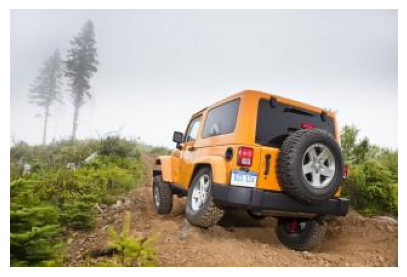

In [157]:
# Listing a sample car image
 
img = image.load_img('data2/images/train/'+class_+'/'+data[1])

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [111]:
# Generate batches of tensor image data with real-time data augmentation

train_datagen = ImageDataGenerator(
     rotation_range=30, # angle range by which the images will randomly rotate
     rescale=1./255.,
     width_shift_range=0.1, # vertical image transformations
     height_shift_range=0.1, # horizontal image transformations
     shear_range=0.1, # random image cropping range
     zoom_range=0.2, # random image zoom range
     horizontal_flip=True, # random flip of half the image in the horizontal plane
     fill_mode='nearest' # strategy for filling newly created pixels that may result from transformations
)

train_gen = train_datagen.flow_from_directory('data2/images/train',
                                              target_size=(128, 128),
                                              batch_size=32,
                                              class_mode='categorical')
test_gen = ImageDataGenerator().flow_from_directory('data2/images/test',
                                                    target_size=(128, 128),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 11193 images belonging to 10 classes.
Found 2798 images belonging to 10 classes.


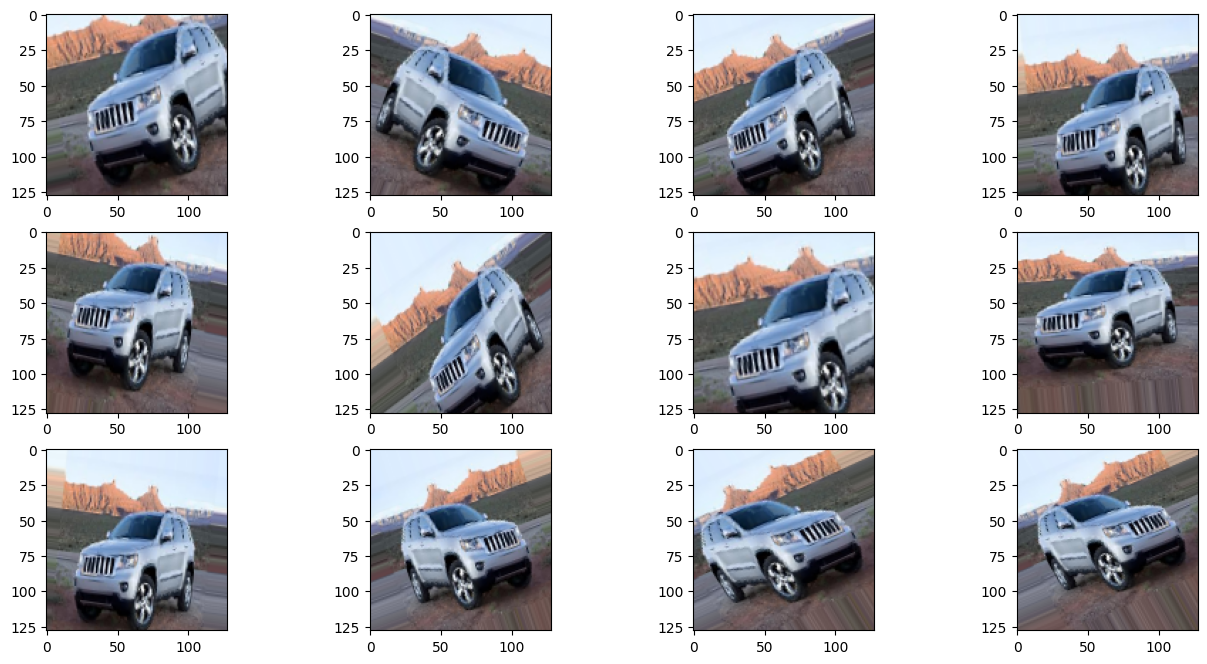

In [158]:
# Sample images obtained using the technique data augmentation

img = image.load_img('data2/images/train/'+class_+'/'+data[11],target_size=(128, 128))# plt.imshow(img)
#img = image.load_img(img_path, target_size=(128, 128))

x = image.img_to_array(img)
x = x.reshape((1, ) + x.shape)

i = 1
plt.figure(figsize=(16, 8))
for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(3, 4, i)
    plt.grid(False)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 13 == 0:
        break

## Build final model

In [113]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
conv_base.trainable = False

In [115]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 8192)              0         
                                                                 
 dense_20 (Dense)            (None, 256)               2097408   
                                                                 
 dense_21 (Dense)            (None, 10)                2570      
                                                                 
Total params: 16814666 (64.14 MB)
Trainable params: 2099978 (8.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [116]:
history = model.fit(train_gen, validation_data=test_gen, batch_size=128, epochs=5)

Epoch 1/5
350/350 [==============================] - 522s 1s/step - loss: 1.7751 - accuracy: 0.3616 - val_loss: 53.0698 - val_accuracy: 0.2034
Epoch 2/5
350/350 [==============================] - 550s 2s/step - loss: 1.4893 - accuracy: 0.4607 - val_loss: 59.4257 - val_accuracy: 0.2641
Epoch 3/5
350/350 [==============================] - 563s 2s/step - loss: 1.3479 - accuracy: 0.5160 - val_loss: 77.8199 - val_accuracy: 0.2691
Epoch 4/5
350/350 [==============================] - 595s 2s/step - loss: 1.2707 - accuracy: 0.5407 - val_loss: 97.4083 - val_accuracy: 0.2688
Epoch 5/5
350/350 [==============================] - 589s 2s/step - loss: 1.2029 - accuracy: 0.5612 - val_loss: 87.3100 - val_accuracy: 0.3181


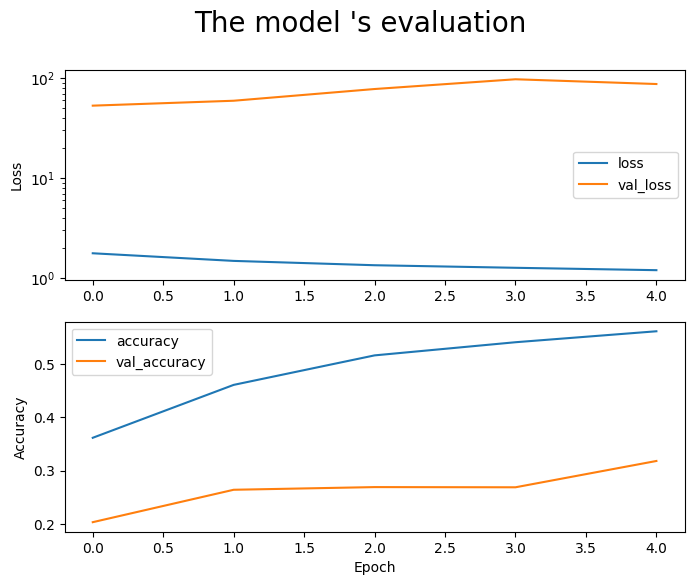

In [117]:
plot_hist(history)

In [118]:
model.save('models/vgg16_model2_10.h5')

/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [119]:
hist_df_vggn = pd.DataFrame(history.history)

## Test final model

In [37]:
# Preparation of test data

test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    'data2/images/test',
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 4734 images belonging to 12 classes.


In [38]:
# Raad class indices

test_generator.class_indices

{'Chevrolet': 0,
 'Ferrari': 1,
 'Ford': 2,
 'GMC': 3,
 'Jeep': 4,
 'Lincoln': 5,
 'McLaren': 6,
 'Mini': 7,
 'Mitsubishi': 8,
 'Porsche': 9,
 'Toyota': 10,
 'Volkswagen': 11}

In [39]:
classes = list(test_generator.class_indices.keys())

In [40]:
# Show input test data class matrix
y_true = test_generator.classes
y_true

array([ 0,  0,  0, ..., 11, 11, 11], dtype=int32)

In [41]:
model = load_model('models/vgg16_model2_10.h5')

In [42]:
# Predict cnn model

y_prob = model.predict(test_generator, test_generator.samples)

4734/4734 [==============================] - 210s 44ms/step


In [43]:
y_pred = np.argmax(y_prob, axis=1)

In [44]:
# Show confusion matrix

cm = confusion_matrix(y_true, y_pred)
cm

array([[  3, 353, 224,  38,  73,   0,  17,  65,  48, 195,   0,   0],
       [  9,   2,   0,   0,   1,   0,   0,   0,   6,   0,   0,   0],
       [  4, 599,  70,  23,  57,   0,   5,  30,  22,  73,   0,   0],
       [  0,  81, 258,  16,  31,   0,   1,  13,   5,  14,   0,   0],
       [  0,  26,  14, 143,  20,   0,   0,  10,   5,  21,   0,   0],
       [  0,  77,   9,   9, 116,   0,   0,  10,   6,  38,   0,   0],
       [  1,   5,   0,   0,   1,   2,   0,   0,   3,   2,   0,   0],
       [  0,  33,   1,   3,   3,   0, 143,   9,   5,  15,   0,   0],
       [  0,  29,   6,   4,   9,   0,   1,  61,   2,  17,   0,   0],
       [  2,  59,   1,   5,  18,   0,   2,   4, 114,  64,   0,   0],
       [  5, 370, 104,  67,  64,   0,  25,  62,  28, 195,   0,   0],
       [  0,  68,   4,  10,  14,   0,   7,   8,   9, 230,   0,   0]])

In [33]:
# Show input test data class matrix
y_true = test_generator.classes
y_true

array([ 0,  0,  0, ..., 11, 11, 11], dtype=int32)

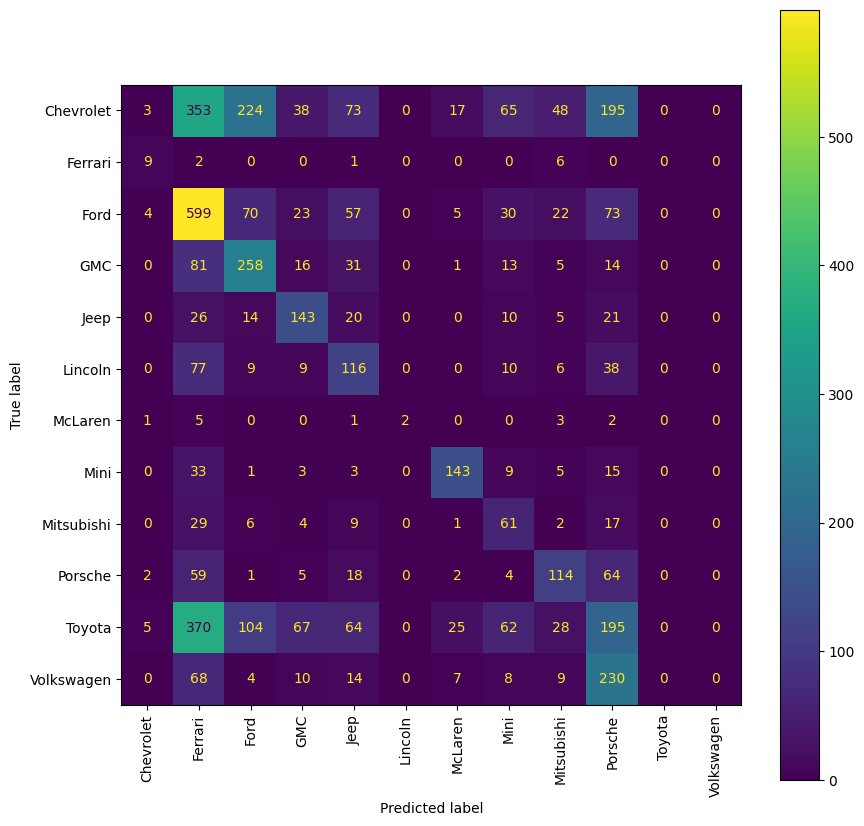

In [34]:
plot_confusion_matrix(cm)

In [35]:
cm = cm/cm.sum(axis=1)

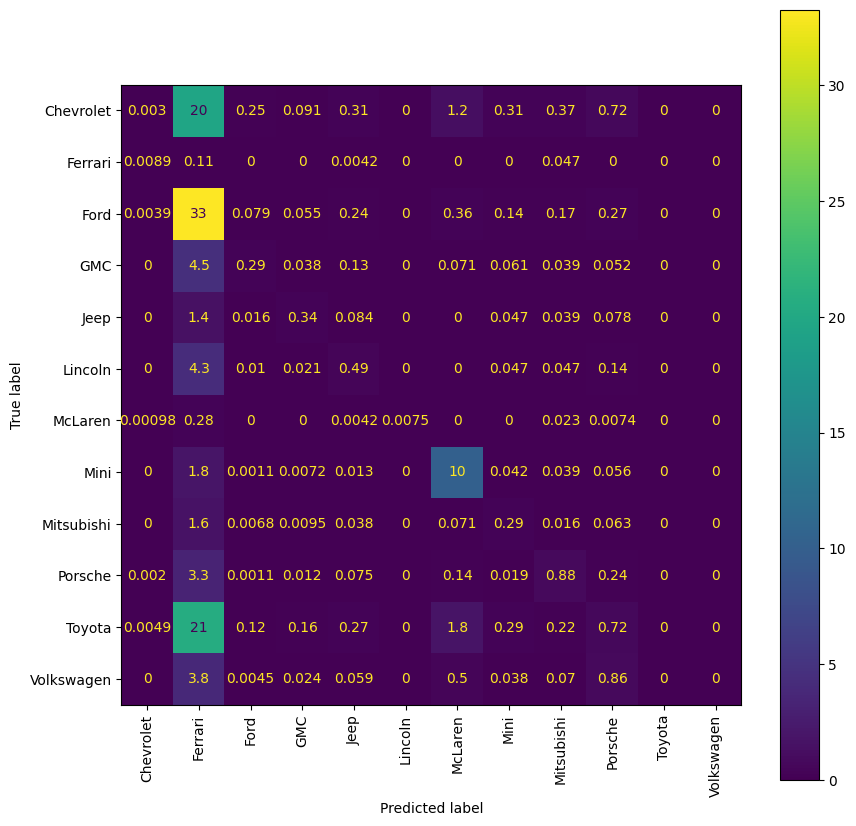

In [36]:
plot_confusion_matrix(cm)

In [45]:
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

   Chevrolet       0.12      0.00      0.01      1016
     Ferrari       0.00      0.11      0.00        18
        Ford       0.10      0.08      0.09       883
         GMC       0.05      0.04      0.04       419
        Jeep       0.05      0.08      0.06       239
     Lincoln       0.00      0.00      0.00       265
     McLaren       0.00      0.00      0.00        14
        Mini       0.03      0.04      0.04       212
  Mitsubishi       0.01      0.02      0.01       129
     Porsche       0.07      0.24      0.11       269
      Toyota       0.00      0.00      0.00       920
  Volkswagen       0.00      0.00      0.00       350

    accuracy                           0.04      4734
   macro avg       0.04      0.05      0.03      4734
weighted avg       0.06      0.04      0.03      4734



/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Verify final model

In [134]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred'])
print(f'Errors in all test files {test_generator.n}:')
errors['is_incorrect'].sum()

Errors in all test files 2798:


1123

In [201]:
classes.index
#[index].apply(lambda x : x.split('/')[-1])
#data['src'].apply(lambda x : x.split('/')[-1].split('_')[0])

<function list.index(value, start=0, stop=9223372036854775807, /)>

1/1 [==============================] - 0s 46ms/step
{'Class': 'Ford', 'Probability': 0.60187215}


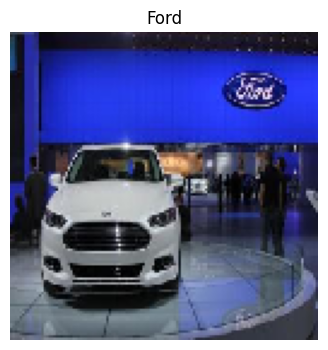

In [152]:
# Correct prediction

img_path = os.path.join('data2/images/test', errors.index[500])
img = image.load_img(img_path)
new_img = image.load_img(img_path, target_size=(128, 128))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

img_class = model.predict(img)
img_class_index =np.argmax(img_class)
classname = classes[img_class_index]
prediction = model.predict(img).max()

pred_dict = {"Class":classname, "Probability":prediction}
print(pred_dict)

#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(classname)
plt.show()

In [153]:
errors.index[500], classes, model.predict(img)

1/1 [==============================] - 0s 60ms/step


('Ford/Ford_Fusion_2013_23_17_170_25_4_72_58_191_22_FWD_5_4_4dr_SRo.jpg',
 ['Ferrari',
  'Ford',
  'GMC',
  'Jeep',
  'Lincoln',
  'McLaren',
  'Mini',
  'Mitsubishi',
  'Porsche',
  'Volkswagen'],
 array([[0.15799387, 0.60187215, 0.03717253, 0.00208791, 0.01337889,
         0.00314213, 0.0278385 , 0.02153198, 0.11144339, 0.02353864]],
       dtype=float32))

1/1 [==============================] - 0s 47ms/step
{'Class': 'Volkswagen', 'Probability': 0.40365067}


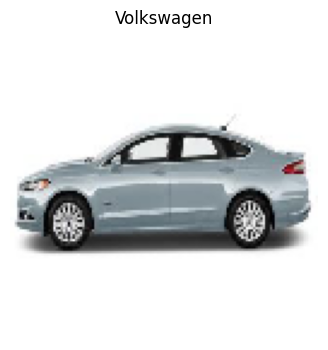

In [155]:
# Incorrect prediction

img_path = os.path.join('data2/images/test', errors.index[504])
img = image.load_img(img_path)
new_img = image.load_img(img_path, target_size=(128, 128))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

img_class = model.predict(img)
img_class_index =np.argmax(img_class)
classname = classes[img_class_index]
prediction = model.predict(img).max()

pred_dict = {"Class":classname, "Probability":prediction}
print(pred_dict)

#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(classname)
plt.show()

In [156]:
errors.index[504], classes, model.predict(img)

1/1 [==============================] - 0s 60ms/step


('Ford/Ford_Fusion_2014_21_16_170_25_4_72_58_191_22_FWD_5_4_4dr_VuZ.jpg',
 ['Ferrari',
  'Ford',
  'GMC',
  'Jeep',
  'Lincoln',
  'McLaren',
  'Mini',
  'Mitsubishi',
  'Porsche',
  'Volkswagen'],
 array([[3.4843333e-04, 1.7254333e-01, 8.4048044e-03, 6.0230670e-03,
         9.3373232e-02, 9.8246775e-05, 5.0629522e-03, 9.0514980e-02,
         2.1998027e-01, 4.0365067e-01]], dtype=float32))

## Summary

In [177]:
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys(), output_dict=True)

In [184]:
rep = pd.DataFrame(report).transpose()

In [185]:
rep['precision'][:10]

Ferrari       0.562500
Ford          0.611849
GMC           0.710744
Jeep          0.671362
Lincoln       0.429630
McLaren       1.000000
Mini          0.899371
Mitsubishi    0.420690
Porsche       0.644068
Volkswagen    0.485232
Name: precision, dtype: float64

In [202]:
test_generator.class_indices

{'Ferrari': 0,
 'Ford': 1,
 'GMC': 2,
 'Jeep': 3,
 'Lincoln': 4,
 'McLaren': 5,
 'Mini': 6,
 'Mitsubishi': 7,
 'Porsche': 8,
 'Volkswagen': 9}

In [206]:
errors[errors['y_pred'] == 5]

,y_true,y_pred,is_incorrect
McLaren/McLaren_720S_2020_299_19_710_40_8_76_47_178_nan_RWD_2_2_2dr_ZtZ.jpg,5,5,False
McLaren/McLaren_720S_2020_299_19_710_40_8_76_47_178_nan_RWD_2_2_2dr_jeh.jpg,5,5,False
